In [81]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
#%matplotlib ipympl
import glob as gb
import csv
import ast
from sklearn import manifold
from time import time
from mpl_toolkits.mplot3d import Axes3D

In [77]:
def img_read(data_folders, res, states, file_ext="JPG", exclude=None, include=None):
    
    total = []
    total_f = []
    total_lb = []
    for df in data_folders:
        img_path = gb.glob(df+'/*.'+file_ext ) 
        
        for path in img_path:
            clb = -1
            pl = path.lower()
            
            if exclude is not None and exclude in pl:  
                continue
            
            if include is not None and include not in pl:
                continue
            

            
            for lb in states:
                if lb in pl:
                    clb = states.index(lb)
                    total_lb.append(clb)
                    break
            
            if clb == -1:
                continue
            
            img1 = cv2.imread(path, cv2.IMREAD_GRAYSCALE)#'data/Resized_256_256xBroken_0.JPG', cv2.IMREAD_GRAYSCALE)
            if img1 is None:                   #判断读入的img1是否为空，为空就继续下一轮循环
                continue
            
            res1= cv2.resize(img1,(res,res))              #对图片进行缩放，第一个参数是读入的图片，第二个是制定的缩放大小
            res1 = cv2.equalizeHist(res1)
            
            norm_image = cv2.normalize(res1, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
            

            
            # Fourier Transform
            f = np.fft.fft2(norm_image)
            fshift = np.fft.fftshift(f)
            fres = 20*np.ma.log(np.abs(fshift))
            fres2 = fres.flatten().tolist()   
            
            res1_1 = norm_image.flatten() #res1_1 = res1.reshape(1,784)/255.0       #将表示图片的二维矩阵转换成一维
            #im_data = np.concatenate((im_data, res1_1))
            res1_1_1 = res1_1.tolist()                     #将numpy.narray类型的矩阵转换成list
            total.append(res1_1_1)  
            total_f.append(fres2)
    
    im_data = np.array(total).astype('float32')
    im_dataf = np.array(total_f).astype('float32')
    im_lb = np.array(total_lb).astype('int32')
    
    #print(im_dataf.shape)
    im_dataf[np.isnan(im_dataf)] = np.nanmean(im_dataf)
    im_dataf[np.isinf(im_dataf)] = np.nanmean(im_dataf)
    
    data = dict()
    data['spatial'] = im_data
    data['freq'] = im_dataf
    data['label'] = im_lb
    return data


def save_data(name, datas, meta):
    file = open(meta,"w") 
    for data in datas:
        file.write(name+'.'+data+'.bin')
        file.write('%')
        file.write('{}'.format(datas[data].shape))
        file.write('%')
        file.write('{}'.format(datas[data].dtype))
        file.write('\n')
        datas[data].tofile(name+'.'+data+'.bin')
    file.close()
    return

def load_data(meta):
    file = open('data/meta',"r")
    data = {}
    for line in file:
        name, shape, dtype = line.split('%')
        dtype = dtype[0:-1]
        cur_data = np.fromfile(name,  dtype=dtype)

        name, shape, dtype = line.split('%')
        n1, data_k, ext = name.split('.')
        shape = ast.literal_eval(shape)
        data[data_k] = cur_data.reshape(shape)
    file.close()        
    return data

def plot_embedding_3d(X, title=None, y=None, colors = ['r', 'g', 'b', 'y']):
    #坐标缩放到[0,1]区间
    x_min, x_max = np.min(X,axis=0), np.max(X,axis=0)
    X = (X - x_min) / (x_max - x_min)
    #降维后的坐标为（X[i, 0], X[i, 1],X[i,2]），在该位置画出对应的digits
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    for i in range(X.shape[0]):
        ax.text(X[i, 0], X[i, 1], X[i,2],str(y[i]),
                 color=colors[y[i]],#plt.cm.Set1(y[i] / colornum),
                 fontdict={'weight': 'bold', 'size': 9})
    if title is not None:
        plt.title(title)

In [61]:
# Preprocess IMG Data
fd = ['data/Paritial/']
res = 64
data = img_read(fd, res, ['dripping', 'jetting', 'wetting', 'broken'])

In [63]:
save_data('data/part', data, 'data/meta')

In [72]:
data_l = load_data('data/meta')

In [62]:
def plot_embedding_3d(X, title=None, colornum = 10):
    #坐标缩放到[0,1]区间
    x_min, x_max = np.min(X,axis=0), np.max(X,axis=0)
    X = (X - x_min) / (x_max - x_min)
    #降维后的坐标为（X[i, 0], X[i, 1],X[i,2]），在该位置画出对应的digits
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    for i in range(X.shape[0]):
        ax.text(X[i, 0], X[i, 1], X[i,2],str(digits.target[i]),
                 color=plt.cm.Set1(y[i] / colornum),
                 fontdict={'weight': 'bold', 'size': 9})
    if title is not None:
        plt.title(title)

In [73]:
im_data = data_l['spatial']
im_dataf = data_l['freq']

from sklearn.decomposition import PCA
pca = PCA(n_components=50)
pcs = pca.fit_transform(im_data)
pcsf = pca.fit_transform(im_dataf)

In [76]:
tsne = manifold.TSNE(n_components=3, init='pca', random_state=0)
t0 = time()
X_tsnes = tsne.fit_transform(pcsf)

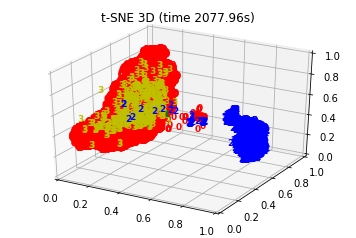

In [82]:
plot_embedding_3d(X_tsnes,"t-SNE 3D (time %.2fs)" %(time() - t0), y=im_lb)

In [85]:
%matplotlib ipympl
#%matplotlib inline

fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('PC 1', fontsize = 15)
ax.set_ylabel('PC 2', fontsize = 15)
ax.set_zlabel('PC 3', fontsize = 15)
ax.set_title('3 component PCA Fourier', fontsize = 20)

targets = [0,1,2,3,4,5,6,7,8,9,10]
states = ['drip','jet','wet','broken']
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan', 'k']

for target, color, state in zip(targets,colors,states):
    ##indicesToKeep = finalDf['target'] == target
    ind = im_lb == target
    ax.scatter(pcsf[ind,0],#finalDf.loc[indicesToKeep, 'principal component 1']
               pcsf[ind,1],#, finalDf.loc[indicesToKeep, 'principal component 2']
               pcsf[ind,2],
               c = color,
               s = 50)
ax.legend(states)
ax.grid()

FigureCanvasNbAgg()